# GWAS Phenotype analysis

This is a tutorial to show how to interprete GWAS analysis using BRICK.

## load packages and data

In [1]:
import BRICK

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['pdf.fonttype'] = 42


url = "neo4j://10.224.28.66:7687"
auth = ("neo4j", "bmVvNGpwYXNzd29yZA==")  

BRICK.config(url=url, auth=auth)
BRICK.config_llm(modeltype='ChatOpenAI', 
                 api_key="sk-kpsteSkpDGl1xBmDEcC7D51b968e43499092826f17286b55",  
                 base_url='http://10.224.28.80:3000/v1', 
                 llm_params={'model_name': 'qwen-max'})

Graph database has been configured and initialized successfully.
LLM has been configured and initialized successfully.


## extract mutation position 

In [10]:
exp_df = pd.read_csv('./data/filtered_mutation.csv',index_col=0)
exp_df.head()

,CHROM,GENPOS,ID,ALLELE0,ALLELE1,INFO,N,TEST,BETA,SE,CHISQ,LOG10P,EXTRA,MaC,P,mut_pos
1962961,10,92590924,.,G,A,1,24412,ADD,-0.130752,0.023870,30.0058,7.36577,NaN,15798,4.307550e-08,NC_000010.11:g.92590924=
1966217,10,92675916,.,G,A,1,25679,ADD,-0.131653,0.021865,36.2539,8.76142,NaN,18761,1.732130e-09,NC_000010.11:g.92675916=
1966472,10,92685036,.,C,T,1,25759,ADD,-0.134525,0.022788,34.8503,8.44847,NaN,17818,3.560660e-09,NC_000010.11:g.92685036=
1966862,10,92700436,.,GT,GTT,1,25441,ADD,-0.124597,0.021669,33.0633,8.04960,NaN,21009,8.920720e-09,NC_000010.11:g.92700436=
1966875,10,92700893,.,T,C,1,25759,ADD,-0.138311,0.022092,39.1975,9.41678,NaN,18984,3.830190e-10,NC_000010.11:g.92700893=


In [12]:
mutation_chrom_pos = list(exp_df['mut_pos'])

## query mutation id

The mutation id in Knowledge Graph is rs-id in dbSNP, the very first step is to align the dataset to rs-id. Here we use CHROM position to query mutation id.

In [13]:
cypher = f"""MATCH (n:Mutation) 
             WHERE ANY(entity IN SPLIT(n.synonym, '|') WHERE entity IN $source_entity_set) RETURN n"""

mut_ids = BRICK.qr.query_cypher(cypher, parameters={'source_entity_set':mutation_chrom_pos})


In [16]:
mut_id_list = list(mut_ids['n.id'])
len(mut_id_list)

94

# Find the most related entities according to mutation

In [17]:
query_df = BRICK.qr.query_neighbor(mut_id_list, source_entity_type='Mutation', query_attribution='id')

In [19]:
count_df = BRICK.rk.match_count(query_df).sort_values('path.2.match_count', ascending=False)
count_df.head()

,path.0.name,path.1.relation,path.1.info_source_length,path.2.id,path.2.name,path.2.type,path.2.match_count
32,"[rs10811662, rs35011184, rs1387153, rs11717195, rs2283228, rs11708067, rs7018475, rs10965248, rs1977833, rs7614016, rs72964564, rs10965250, rs76895963, rs849134, rs10965247, rs35198068, rs7756992, rs7766070, rs10830962, rs849135, rs860262, rs35261542, rs4506565, rs4506565, rs10440833, rs10965246, rs6931514, rs10830963, rs34872471, rs12243326, rs12243326, rs1635852, rs2237896, rs9368222, rs35906730, rs7901695, rs12255372, rs12255372, rs2877716, rs864745]","[causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, pharmaco_effect_on, pharmaco_effect_on, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, pharmaco_effect_on, pharmaco_effect_on, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, pharmaco_effect_on, pharmaco_effect_on, causally_related_to, causally_related_to]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",MESH:D003924,"Diabetes Mellitus, Type 2",Disease,37
175,"[rs10811662, rs35011184, rs1387153, rs11717195, rs2283228, rs11708067, rs7018475, rs10965248, rs1977833, rs7614016, rs72964564, rs10965250, rs76895963, rs849134, rs10965247, rs35198068, rs7756992, rs7766070, rs10830962, rs849135, rs860262, rs35261542, rs10440833, rs10965246, rs6931514, rs10830963, rs34872471, rs1635852, rs2237896, rs9368222, rs35906730, rs7901695, rs2877716, rs864745]","[causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to, causally_related_to]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",DOID:9352,type 2 diabetes mellitus,Disease,34
104,"[rs12255678, rs10885409, rs35011184, rs56299331, rs7074440, rs4073288, rs12255372, rs10885402, rs11196175, rs7904519, NM_001367943.1(TCF7L2):c.451-22114C>T, rs17747324, rs35198068, rs72826094, NM_001367943.1(TCF7L2):c.451-25858C>T, NM_001367943.1(TCF7L2):c.451-14360G>A, rs4367880, NM_001367943.1(TCF7L2):c.451-22060A>G, rs10885405, rs6585202, rs75933965, rs34872471, rs61872790, rs11196180, NM_001367943.1(TCF7L2):c.450+33966C>G, rs11196205, rs7901695, NM_001367943.1(TCF7L2):c.451-22388C>T, rs7903146, rs4074718, rs11196174, rs11196187]","[sequentially_related_to, sequentially_related_to, sequentially_related_to, sequentially_related_to, sequentially_related_to, sequentially_related_to, sequentially_related_to, sequentially_related_to, sequentially_related_to, sequentially_related_to, sequentially_related_to, sequentially_related_to, sequentially_related_to, sequentially_related_to, sequentially_related_to, sequentially_related_to, sequentially_related_to, sequentially_related_to, sequentially_related_to, sequentially_related_to, sequentially_related_to, sequentially_related_to, sequentially_related_to, sequentially_related_to, sequenti

In [22]:
count_df_head = count_df.loc[(count_df['path.2.match_count'] > 5)]

In [23]:
nxg = BRICK.pp.df2nxg(count_df_head)

In [27]:
nodes_attr_mapping = {'KG_Mutation': {'shape':'circle', 'color':'#f8cf65', 'size':10 }, 
                      'Gene': {'shape':'circle', 'color':'#79E9E2', 'size':10 },
                      'KG_Gene': {'shape':'circle', 'color':'#79E9E2', 'size':10 },
                      'KG_Chemical': {'shape':'circle', 'color':'#a5f498', 'size':30 },
                      'KG_Phenotype' : {'shape':'circle', 'color':'#faab44', 'size':30 }, 
                      'KG_Disease' : {'shape':'circle', 'color':'#fd9c9c', 'size':30 },
                      'KG_Other' : {'shape':'circle', 'color':'#B9B9B9', 'size':30 },
                      'KG_Pathway' : {'shape':'circle', 'color':'#B9B9B9', 'size':30 },
                      'KG_Process' : {'shape':'circle', 'color':'#B9B9B9', 'size':30 }
                     }
for x in nxg.nodes:
    attr = nodes_attr_mapping[nxg.nodes[x]['type']]
    for i, j in attr.items():
        nxg.nodes[x][i] = j

for x in nxg.edges:
    nxg.edges[x]['weight'] = 10

d:\downloads\nlp\kg_repo\BRICK\plotting\static_graph.py:288: UserWarning: 

The arrowstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(
d:\downloads\nlp\kg_repo\BRICK\plotting\static_graph.py:301: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


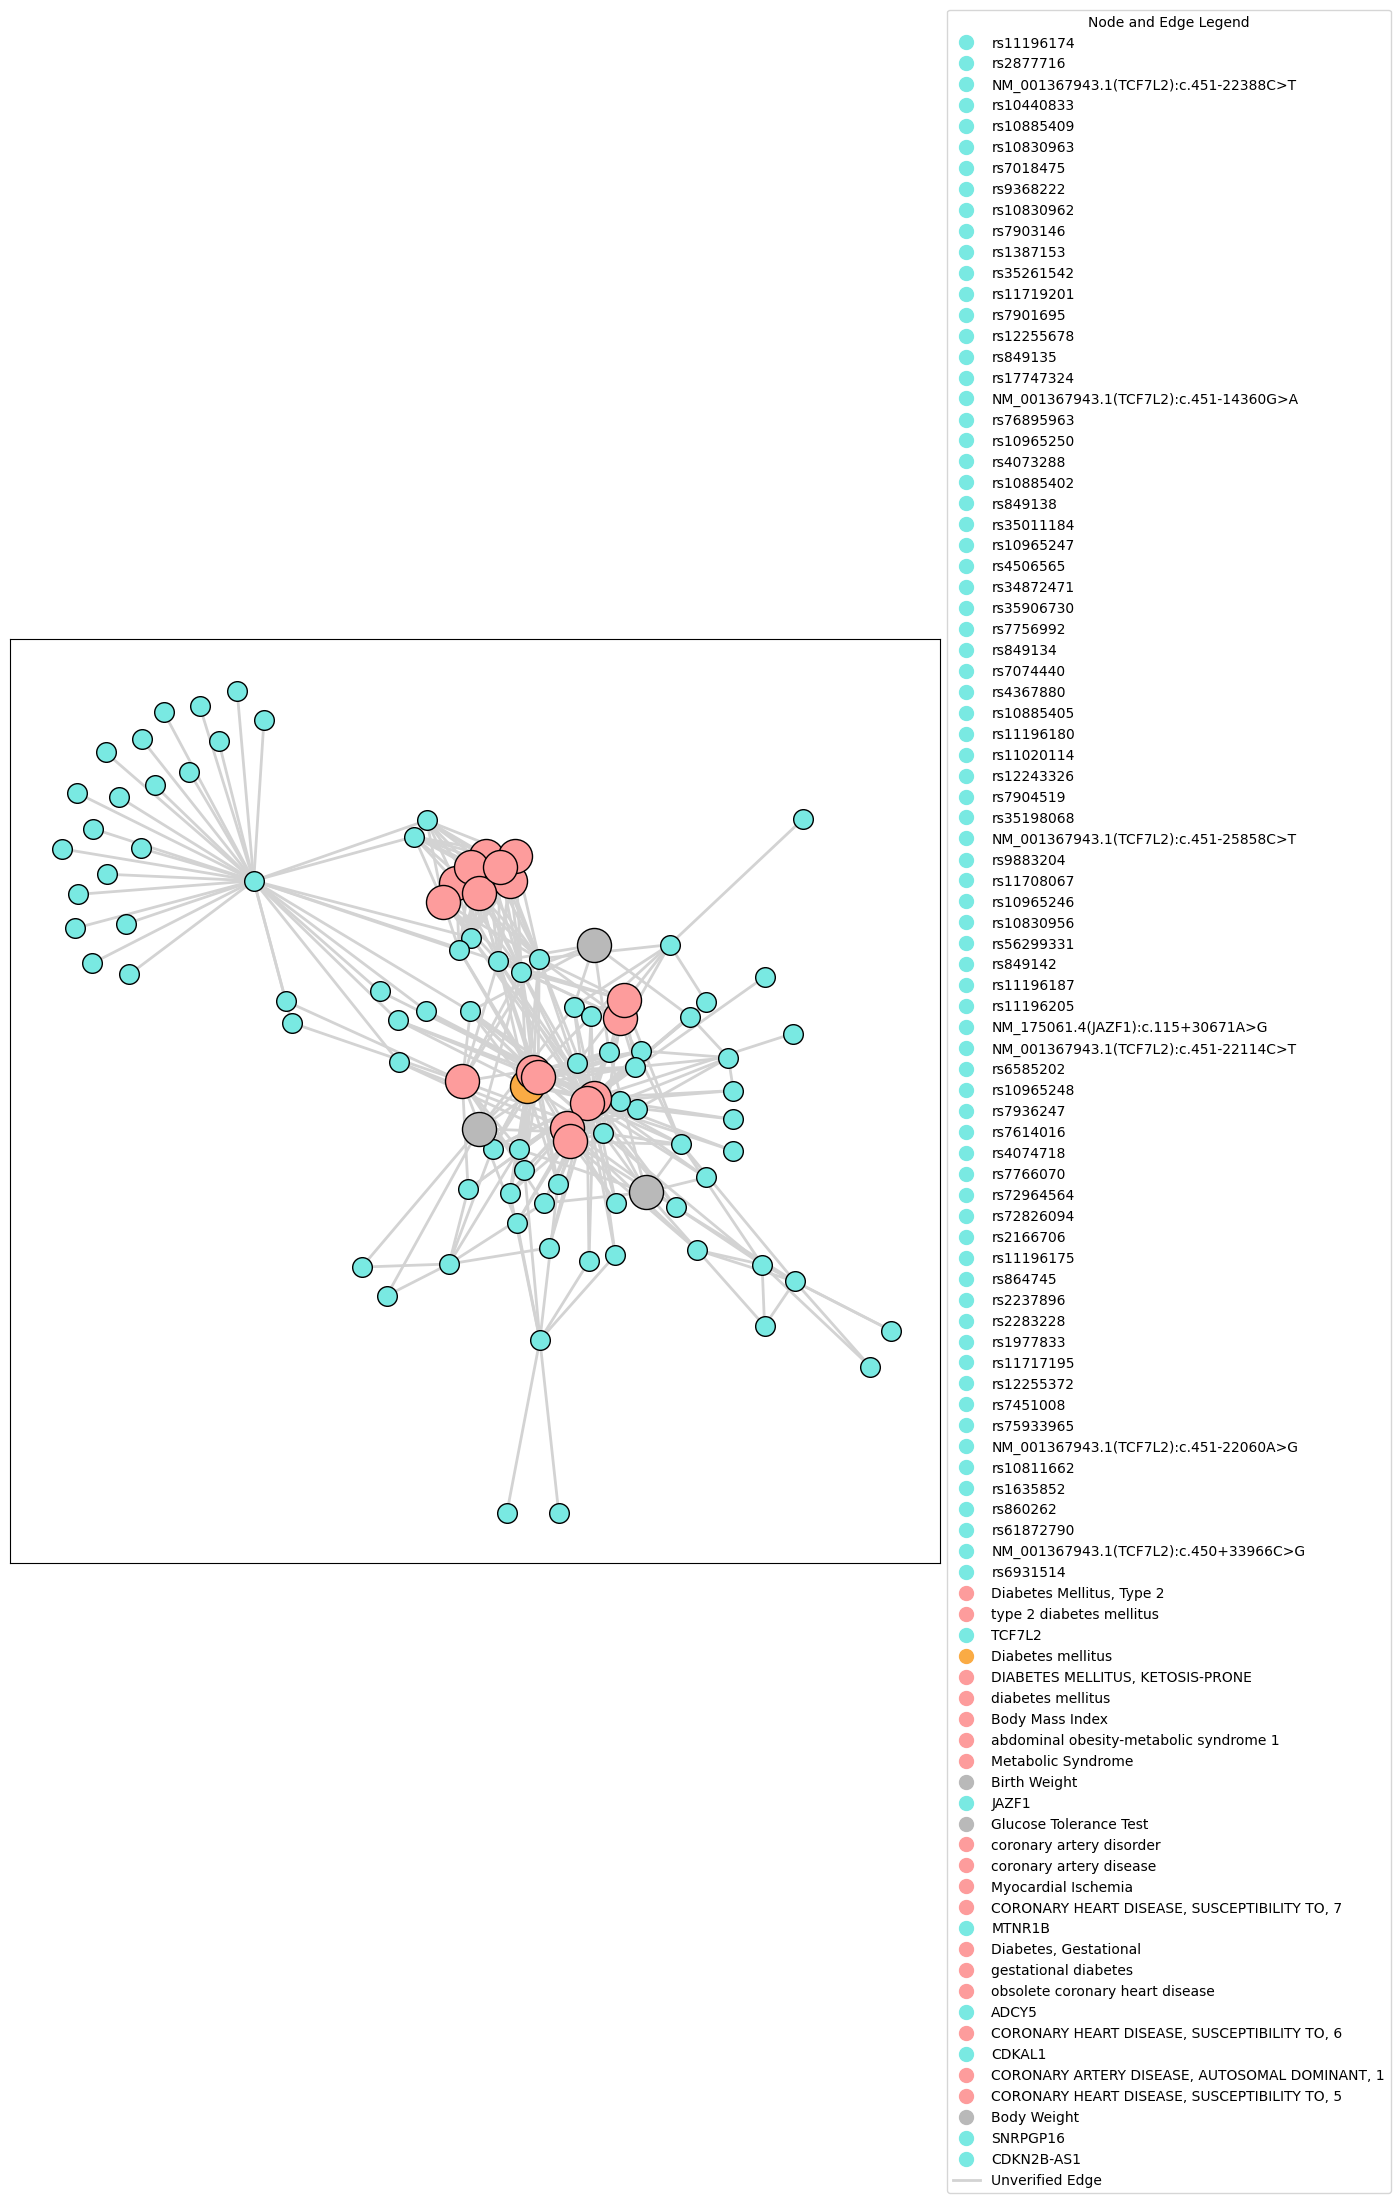

In [29]:
BRICK.pl.static_visualize_network(nxg, figsize=(12, 12), default_edge_color='lightgrey')

In [32]:
print(BRICK.inp.interpret_results('This is an anlysis result of GWAS data, What the most related phenotype?',
                            queried_snp_related_to_phenotype = count_df_head[['path.0.name', 'path.2.name', 'path.2.match_count']]))

### 1. Reasoning the Analysis Result

- **Key Evidence Chain and Statistical Significance:**
  - The analysis identifies a set of SNPs (e.g., rs10811662, rs35011184, rs1387153) that are frequently associated with various phenotypes.
  - The most significant phenotype is "Diabetes Mellitus, Type 2" with the highest match count (37).
  - Other related phenotypes include "type 2 diabetes mellitus" (34), "TCF7L2" (32), and "Diabetes mellitus" (16).

- **Reasonability of the Analysis Result:**
  - The high frequency of SNPs associated with type 2 diabetes is consistent with existing literature, where multiple genetic variants are known to contribute to the disease.
  - The presence of TCF7L2, a well-known gene associated with type 2 diabetes, further supports the validity of the analysis.
  - The association with other metabolic disorders such as "abdominal obesity-metabolic syndrome" and "Metabolic Syndrome" (both with 11 matches) is also reasonable, as these conditions often co-occur with